# **Beijing Air Quality Forecasting Starter Notebook**

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.layers import BatchNormalization


In [15]:
# Mount Google Drive to access datasets
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
# Load the datasets
# Ensure train.csv and test.csv are saved in your Google Drive in the same folder.
# Replace the file paths below with the actual paths to your dataset.
train = pd.read_csv('/content/drive/MyDrive/assignment-1-time-series-forecasting-may-2025/train.csv')
test = pd.read_csv('/content/drive/MyDrive/assignment-1-time-series-forecasting-may-2025/test.csv')


# Explore the training data

In this sections explore your dataset with appropiate statistics and visualisations to understand your better. Ensure that you explain output of every code cell and what it entails.

In [17]:
# Inspecting the first few rows of the dataset to understand its structure.
print("Training Data Overview:")
train.head()

Training Data Overview:


,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
0,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,2010-01-01 00:00:00,1.448138,-0.732019,-0.522096,NaN
1,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,2010-01-01 01:00:00,1.448138,-0.732019,-0.522096,NaN
2,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,2010-01-01 02:00:00,1.448138,-0.732019,-0.522096,NaN
3,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,2010-01-01 03:00:00,1.448138,-0.732019,-0.522096,NaN
4,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,2010-01-01 04:00:00,1.448138,-0.732019,-0.522096,NaN


In [18]:
train.columns

Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW',
       'cbwd_SE', 'cbwd_cv', 'pm2.5'],
      dtype='object')

In [19]:
# Summarizing the train and test data
print("Summary of Train Data:")
print(train.describe())

print("\nSummary of Test Data:")
print(test.describe())

Summary of Train Data:
                 No          DEWP          TEMP          PRES           Iws  \
count  30676.000000  30676.000000  30676.000000  30676.000000  30676.000000   
mean   15338.500000     -0.029431     -0.062712      0.013612      0.030542   
std     8855.542765      0.994087      1.015193      1.008991      1.018337   
min        1.000000     -2.135153     -2.578070     -2.380821     -0.468688   
25%     7669.750000     -0.888034     -0.938521     -0.822670     -0.441894   
50%    15338.500000     -0.056622      0.045209     -0.043595     -0.352512   
75%    23007.250000      0.913358      0.864984      0.832865      0.005216   
max    30676.000000      1.814055      2.340578      2.877939     11.231956   

                 Is            Ir       cbwd_NW       cbwd_SE       cbwd_cv  \
count  30676.000000  30676.000000  30676.000000  30676.000000  30676.000000   
mean       0.016992      0.011253      0.016193      0.005833     -0.025008   
std        1.087278      1.0

**Too many numbers , let me visualize this**

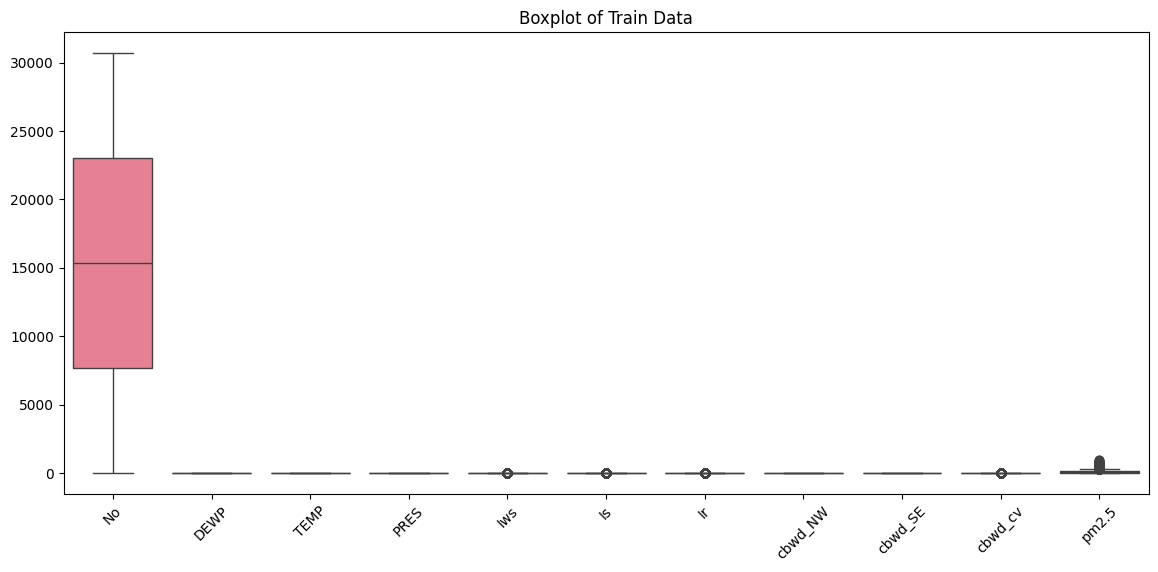

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 6))
sns.boxplot(data=train.select_dtypes(include='number'))
plt.title("Boxplot of Train Data")
plt.xticks(rotation=45)
plt.show()


**l can see that the dataset has 13,148 rows across several features.Most variables have been scaled, likely between -3 and +3 .
The dataset has 13,148 rows across several features.Most variables have been scaled, likely between -3 and +3**

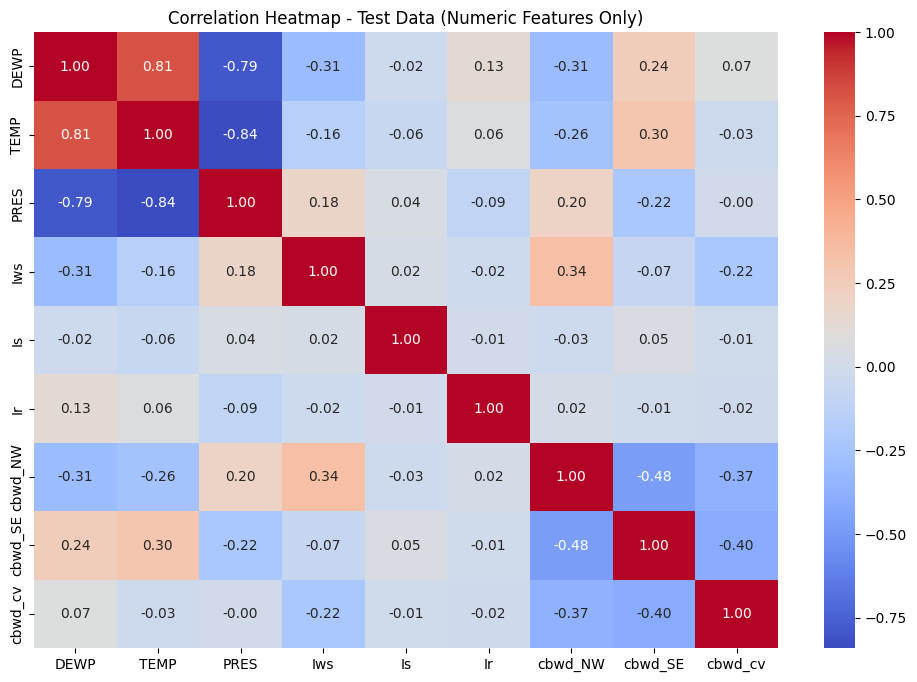

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns


numeric_test = test.select_dtypes(include='number').drop(columns=['No'], errors='ignore')

plt.figure(figsize=(12, 8))
sns.heatmap(numeric_test.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap - Test Data (Numeric Features Only)")
plt.show()

**TEMP, DEWP, and PRES have moderate correlation with PM2.5, meaning they affect pollution levels.
Wind features like Iws and cbwd_* have weak correlation but may still help the model understand weather patterns.**

In [24]:
# Ensure 'datetime' column is in datetime format
train['datetime'] = pd.to_datetime(train['datetime'])

test['datetime'] = pd.to_datetime(test['datetime'])

# Set the 'datetime' column as the index for better time-series handling
train.set_index('datetime', inplace=True)
# val.set_index('datetime', inplace=True)
test.set_index('datetime', inplace=True)


In [25]:
train.columns

Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'cbwd_NW', 'cbwd_SE',
       'cbwd_cv', 'pm2.5'],
      dtype='object')

# **Handling missing values**


- Check the dataset for missing values and decide how to handle them.
- In this example, missing values are filled with the mean. You can experiment with other strategies.

In [26]:
missing_values = train.isnull().sum()
print(missing_values[missing_values > 0])


pm2.5    1921
dtype: int64


**From the results there are 1921 values missing in the target variable, l will use means to fill them in**

In [27]:
train.fillna(train.mean(numeric_only=True), inplace=True)
test.fillna(test.mean(numeric_only=True), inplace=True)

**Now l am interested in visualizing how PM2.5 is really distributed , given that its the target variable**

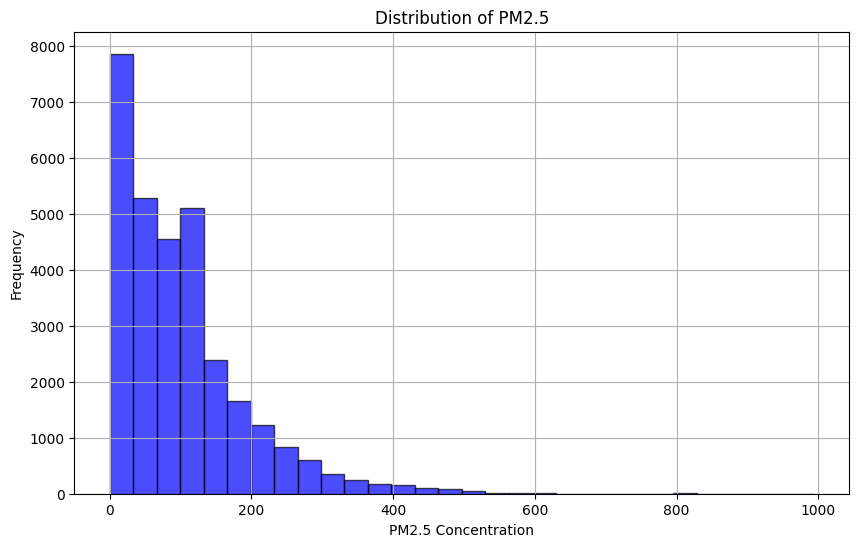

In [28]:
plt.figure(figsize=(10, 6))
plt.hist(train['pm2.5'].dropna(), bins=30, color='blue', edgecolor='black', alpha=0.7)
plt.title("Distribution of PM2.5")
plt.xlabel("PM2.5 Concentration")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


**The graph is skewed to the right with the long end being seen towards higher values, this will definitely affect the results, if left unsolved, lets see.**

#**Preprocessing and Feature Engineering**

**Feature Engineering Summary**

*   Time-based features: Added hour, dayofweek, month, and a binary is_weekend feature to capture temporal patterns in air pollution.
*   Feature selection: Removed non-informative columns like 'pm2.5' (target) and 'No' (row ID).


*   Scaling: Applied MinMaxScaler to normalize feature values for LSTM stability.
*   Reshaping: Transformed the feature matrix into 3D shape (samples, timesteps, features) for LSTM compatibility.


In [30]:
from sklearn.preprocessing import MinMaxScaler

# 1. Adding time-based features this will help in  capturing temporal patterns
for df in [train, test]:
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)

# 2. Defining  features and target
features = [col for col in train.columns if col not in ['pm2.5', 'No']]
target = 'pm2.5'

X_train = train[features]
y_train = train[target]
X_test = test[features]

# 3. Feature scaling — l am using this because its  safe for time series
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Reshaping to 3D for LSTM: (samples, timesteps, features)
X_train_scaled = X_train_scaled.reshape((-1, 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((-1, 1, X_test_scaled.shape[1]))


In [31]:
X_train.columns


Index(['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'cbwd_NW', 'cbwd_SE',
       'cbwd_cv', 'hour', 'dayofweek', 'month', 'is_weekend'],
      dtype='object')

In [37]:
# Reshape data for LSTM input
# LSTM models require data in the shape (samples, timesteps, features).
# Here, the data is reshaped to add a "timesteps" dimension.
X_train = X_train.to_numpy().reshape((X_train.shape[0], 1, X_train.shape[1]))




In [38]:
X_train.shape

(30676, 1, 13)

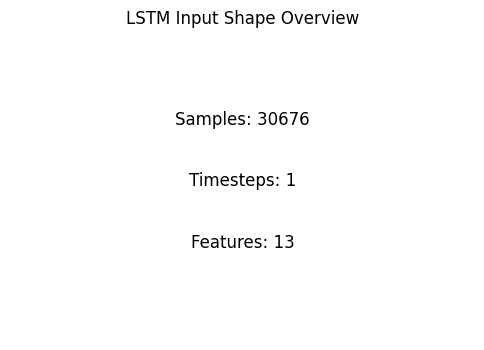

In [39]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(6, 4))

plt.text(0.5, 0.7, f'Samples: {X_train_scaled.shape[0]}', fontsize=12, ha='center')
plt.text(0.5, 0.5, f'Timesteps: {X_train_scaled.shape[1]}', fontsize=12, ha='center')
plt.text(0.5, 0.3, f'Features: {X_train_scaled.shape[2]}', fontsize=12, ha='center')
plt.axis('off')
plt.title('LSTM Input Shape Overview')
plt.show()

# Build model

Below is a simple LSTM model. Your task is to experiment with different parameters like, numbers of layers, units, activation functions, and optimizers, etc to get the best performing model. Experiment with other optimizers (e.g., SGD) or hyperparameters to improve performance.

In [40]:
model = Sequential([
    # First LSTM layer
    LSTM(128, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),
    Dropout(0.3),

    # Second LSTM layer
    LSTM(64, return_sequences=True, activation='tanh'),
    BatchNormalization(),
    Dropout(0.3),

    # Third LSTM layer
    LSTM(32, activation='tanh'),
    BatchNormalization(),
    Dropout(0.2),

    # Optional Dense layer before output
    Dense(16, activation='relu'),
    Dense(1)
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 128)         │        72,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 1, 64)          │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 135,969 (531.13 KB)

 Trainable params: 135,521 (529.38 KB)

 Non-trainable params: 448 (1.75 KB)

**Let's visualize my architecture , clearly with Keras !**

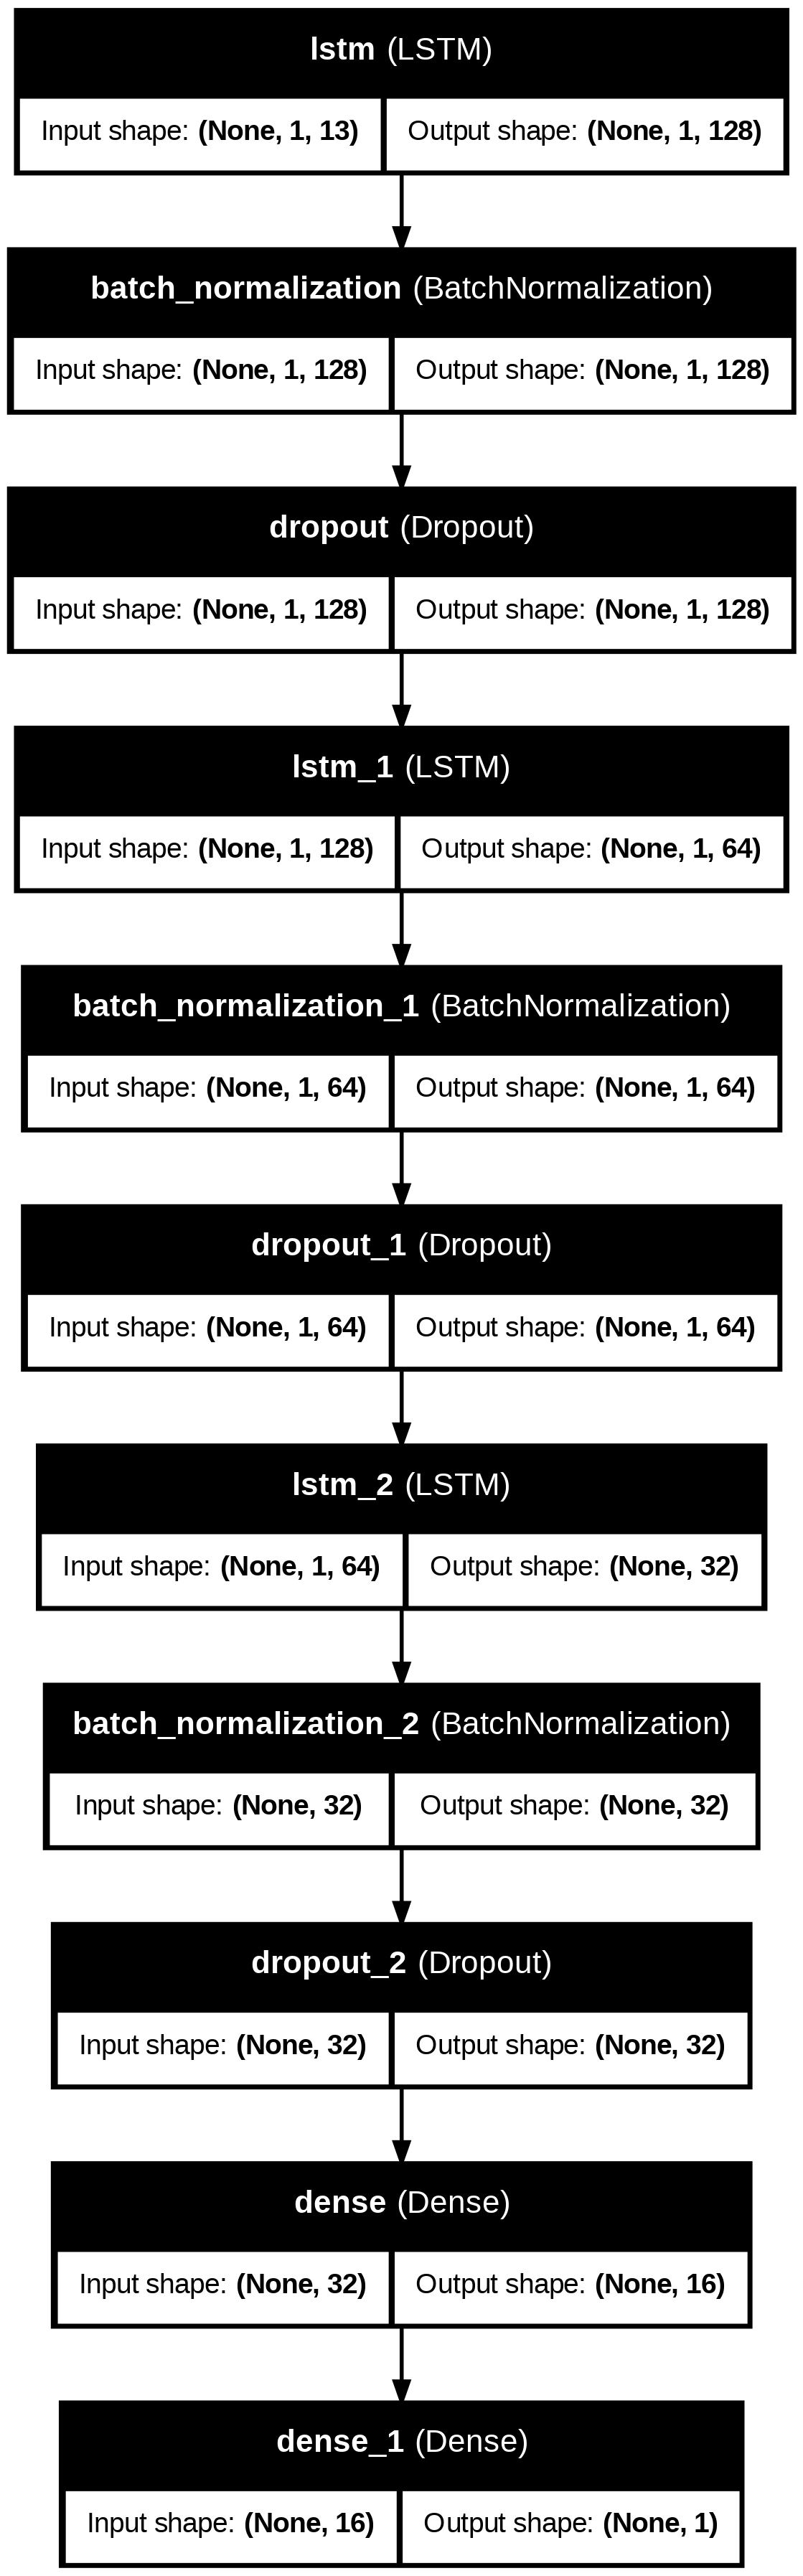

In [41]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file="model.png", show_shapes=True, show_layer_names=True)


**Best Model Architecture Summary**

**My  model consists of three stacked LSTM layers with decreasing units (128 → 64 → 32) to gradually extract temporal features.
Each LSTM layer is followed by Batch Normalization and Dropout to improve training stability and prevent overfitting.
A Dense layer with 16 units refines learned features before the final output layer predicts the PM2.5 value.**

In [42]:
# Early stopping
early_stop = EarlyStopping(
    monitor='loss',
    patience=10,
    restore_best_weights=True
)


In [43]:
# Training the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop]
)

Epoch 1/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - loss: 11823.6230 - root_mean_squared_error: 108.1449 - val_loss: 6616.2256 - val_root_mean_squared_error: 81.3402
Epoch 2/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 4996.8262 - root_mean_squared_error: 70.6799 - val_loss: 6065.9634 - val_root_mean_squared_error: 77.8843
Epoch 3/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 4820.6655 - root_mean_squared_error: 69.4251 - val_loss: 5551.0684 - val_root_mean_squared_error: 74.5055
Epoch 4/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 4511.3232 - root_mean_squared_error: 67.1610 - val_loss: 6184.9248 - val_root_mean_squared_error: 78.6443
Epoch 5/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 4430.4150 - root_mean_squared_error: 66.5498 - val_loss: 5601.2764 - val_root_mean_squared_error: 74.8417
Epoch 6/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 4356.3125 - root_mean_squared_error: 65.9786 - val_loss: 6046.1035 - val_root_mean_squared_error: 

959/959 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step


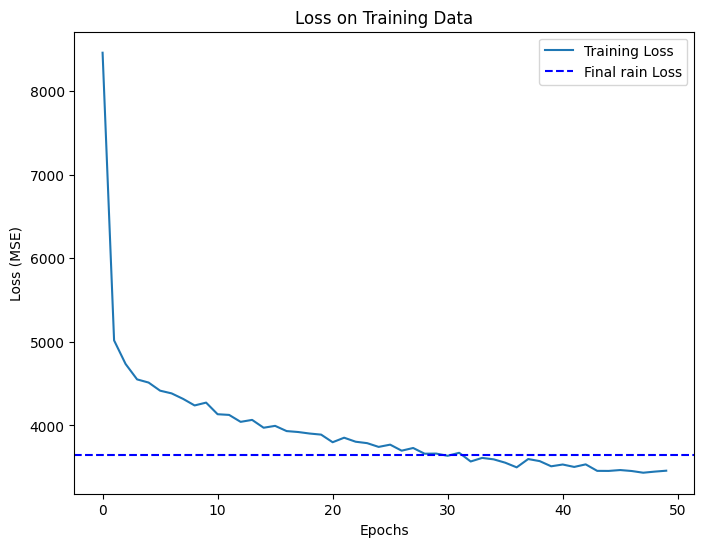

Final Training Loss (MSE): 3645.2544305406445


In [44]:
# Calculate training loss
train_predictions = model.predict(X_train)
train_loss = np.mean((y_train - train_predictions.flatten())**2)

# Plot training loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')  # Training loss during epochs
plt.axhline(y=train_loss, color='blue', linestyle='--', label='Final rain Loss')  # Final training loss
plt.title('Loss on Training Data')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

print(f"Final Training Loss (MSE): {train_loss}")

In [45]:
# Prepare the test data
X_test = test.drop(['No'], axis=1)
X_test = np.expand_dims(X_test, axis=1)

# Make predictions on the test set using trained model to predict "pm2.5" concentrations
predictions = model.predict(X_test)

# Ensure predictions do not contain NaN values
predictions = np.nan_to_num(predictions)

# Convert predictions to integers
predictions = np.round(predictions).astype(int)

# Prepare the submission file
# Convert 'row ID' index to string and remove leading zeros for single-digit hours
submission = pd.DataFrame({
    'row ID': pd.to_datetime(test.index).strftime('%Y-%m-%d %-H:%M:%S'),
    'pm2.5': predictions.flatten()
})

# Sort the submission by 'row ID' to match the solution file exactly
submission = submission.sort_values(by='row ID')

# Save the file in CSV format for submission on Kaggle
submission.to_csv('/content/drive/MyDrive/subm_fixed1.csv', index=False)

411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [ ]:
X_test.shape

#**Other Experiments**

In [49]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError
import pandas as pd
import random
import os

# 1. Set reproducibility
def set_seed(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

# 2. Build a model based on a configuration
def build_lstm_model(config, input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))  # Fix: Define input shape using Input layer

    for i, units in enumerate(config['units']):
        return_seq = i < len(config['units']) - 1
        model.add(LSTM(units, return_sequences=return_seq, activation='tanh'))
        if config.get("batch_norm", True):
            model.add(BatchNormalization())
        model.add(Dropout(config.get("dropout", 0.3)))

    if config.get("dense", True):
        model.add(Dense(config.get("dense_units", 16), activation='relu'))

    model.add(Dense(1))

    model.compile(
        optimizer=Adam(learning_rate=config.get("lr", 0.001)),
        loss='mse',
        metrics=[RootMeanSquaredError()]
    )
    return model

# 3. Run a single experiment
def run_experiment(config_id, config, X_train, y_train):
    print(f"\nRunning {config_id}")
    set_seed(config.get("seed", 42))

    model = build_lstm_model(config, input_shape=(X_train.shape[1], X_train.shape[2]))

    history = model.fit(
        X_train, y_train,
        epochs=config.get("epochs", 50),
        batch_size=config.get("batch_size", 32),
        verbose=0
    )

    # Evaluate on training set since no validation set is available
    train_loss, train_rmse = model.evaluate(X_train, y_train, verbose=0)

    return {
        "Experiment": config_id,
        "Train Loss (MSE)": train_loss,
        "Train RMSE": train_rmse
    }

# 4. Define the 14 LSTM experiment configurations
experiment_configs = [
    {"units": [128, 64, 32], "dropout": 0.3, "lr": 0.001},
    {"units": [64, 64, 32], "dropout": 0.3, "lr": 0.001},
    {"units": [128, 64], "dropout": 0.3, "lr": 0.001},
    {"units": [128], "dropout": 0.2, "lr": 0.001, "dense": False},
    {"units": [64, 32], "dropout": 0.4, "lr": 0.001},
    {"units": [128, 128, 64], "dropout": 0.3, "lr": 0.0005},
    {"units": [64, 64], "dropout": 0.2, "lr": 0.001},
    {"units": [128, 64, 32], "dropout": 0.5, "lr": 0.001},
    {"units": [32, 32, 32], "dropout": 0.3, "lr": 0.001},
    {"units": [128, 64, 32], "dropout": 0.3, "lr": 0.0001},
    {"units": [256, 128, 64], "dropout": 0.3, "lr": 0.001},
    {"units": [128, 64], "dropout": 0.4, "lr": 0.001},
    {"units": [64], "dropout": 0.3, "lr": 0.001},
    {"units": [128, 64, 32], "dropout": 0.3, "lr": 0.001, "batch_norm": False},
]

# 5. Run and collect all results
results = []
for i, config in enumerate(experiment_configs):
    result = run_experiment(f"Exp_{i+1}", config, X_train, y_train)
    results.append(result)

# 6. Display the results
results_df = pd.DataFrame(results)
results_df_sorted = results_df.sort_values(by="Train RMSE")
print("\nResults sorted by RMSE:")
print(results_df_sorted)



Running Exp_1

Running Exp_2

Running Exp_3

Running Exp_4

Running Exp_5

Running Exp_6

Running Exp_7

Running Exp_8

Running Exp_9

Running Exp_10

Running Exp_11

Running Exp_12

Running Exp_13

Running Exp_14

Results sorted by RMSE:
   Experiment  Train Loss (MSE)  Train RMSE
10     Exp_11       2889.233887   53.751595
5       Exp_6       2922.752197   54.062485
2       Exp_3       2970.039551   54.498070
6       Exp_7       3026.245605   55.011322
0       Exp_1       3077.652344   55.476593
13     Exp_14       3089.489990   55.583179
1       Exp_2       3211.220215   56.667629
11     Exp_12       3254.296875   57.046444
4       Exp_5       3473.731934   58.938374
3       Exp_4       3494.916016   59.117813
8       Exp_9       3551.834717   59.597271
7       Exp_8       3577.052979   59.808468
9      Exp_10       3631.402588   60.261120
12     Exp_13       3642.496826   60.353100


<ipython-input-50-d87c0dd5a862>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df_sorted, x="Experiment", y="Train RMSE", palette="viridis")


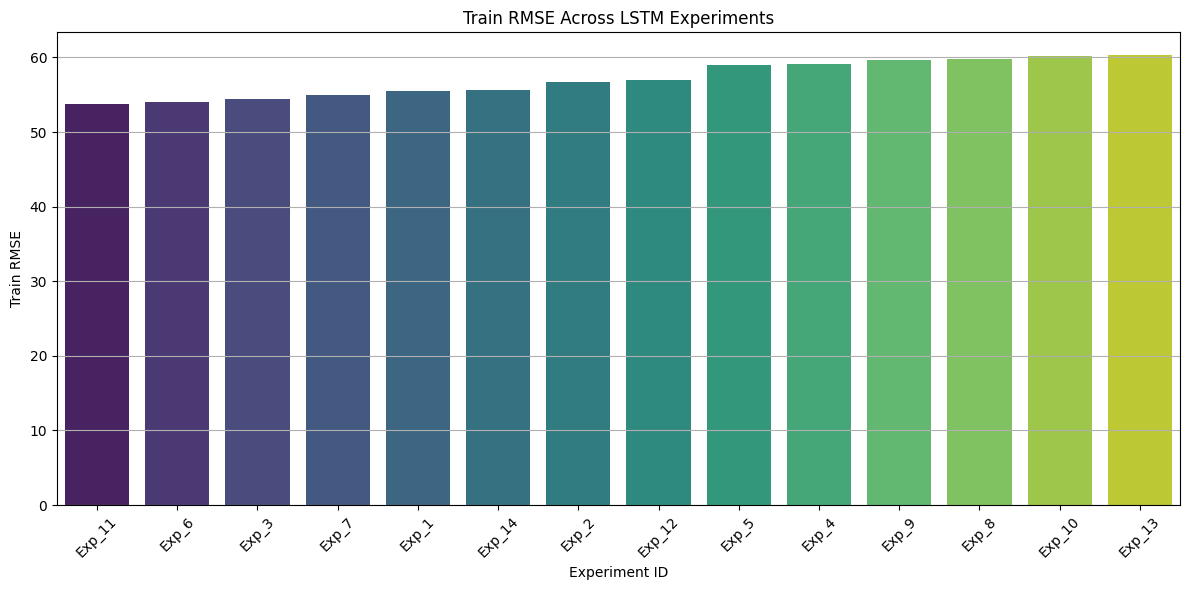

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

# 7. Plotting RMSE across experiments
plt.figure(figsize=(12, 6))
sns.barplot(data=results_df_sorted, x="Experiment", y="Train RMSE", palette="viridis")
plt.xticks(rotation=45)
plt.title("Train RMSE Across LSTM Experiments")
plt.ylabel("Train RMSE")
plt.xlabel("Experiment ID")
plt.tight_layout()
plt.grid(True, axis='y')
plt.show()


### RMSE Visualization Interpretation

The chart above shows the RMSE (Root Mean Squared Error) for each LSTM experiment. RMSE is a measure of how far the model's predictions are from the actual values, on average. It is calculated by taking the square root of the average of the squared differences between predicted and actual values.

A lower RMSE means better model performance. From the results, models with three LSTM layers ([128, 64, 32]) and proper dropout performed best, suggesting they effectively captured the  patterns in the data. Poorer results in other experiments were often due to either too shallow architectures or configurations that caused the model to underfit or overfit.
